In [1]:
import os 
import warnings

import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib as plt

sc.settings.verbosity = 0
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
os.chdir('YOUR PROJECT PATH')

In [3]:
filenames = os.listdir('./data/')

In [4]:
# Read all files
adata_list = []

for file in filenames:
    
    gsm = file.split('_')[0]
    
    adata = sc.read_10x_h5(f'./data/{file}')
    
    sc.pp.filter_cells(adata, min_genes=200)
    
    sc.pp.filter_genes(adata, min_cells=3)
    
    adata.obs['sample'] = gsm
    
    adata.obs_names = [f"{gsm}_{cell}" for cell in adata.obs_names]
    
    adata.var_names_make_unique()
    
    adata_list.append(adata)

In [5]:
# Arrange datasets into one object
adata = sc.concat(adata_list, axis = 0, merge="same", join = 'outer')

# Filtering

In [6]:
# Calculate percentage of mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None)

In [7]:
# I just used the same thresholds as in Seurat
print("adata: matrix size before filtering (cells*genes):", adata.shape)
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]
adata = adata[adata.obs.total_counts < 70000, :]
print("adata: matrix size after filtering (cells*genes):", adata.shape)

adata: matrix size before filtering (cells*genes): (158027, 26181)
adata: matrix size after filtering (cells*genes): (146139, 26181)


# Scrublet

In [8]:
# Calculate doublet scores separately for each batch
sc.pp.scrublet(adata, batch_key = 'sample')

In [9]:
adata.write('./adata/adata_filtered_scrublet.h5ad')

In [10]:
adata.obs.to_csv('./adata/metadata.csv')

In [11]:
adata = sc.read('./adata/adata_filtered_scrublet.h5ad')

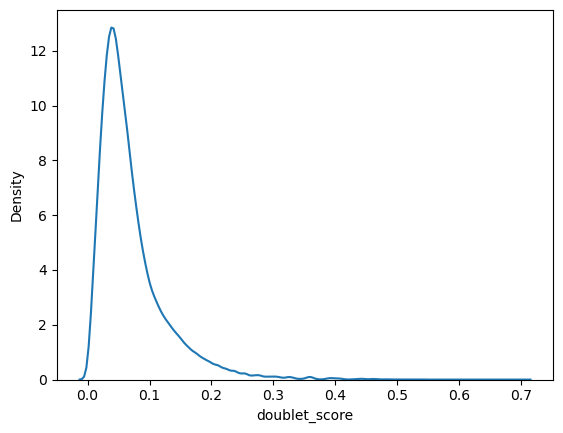

In [12]:
# Plot scrublet score distribution
ax = sns.kdeplot(adata.obs.doublet_score)
plt.pyplot.savefig('./figures/doublet_score_distribution.png', dpi = 300)